In [111]:
import azure.ai.ml 

In [112]:
# import required libraries
from azure.ai.ml import MLClient
from azure.identity import DefaultAzureCredential
from azure.ai.ml import command, Input
from azure.ai.ml.entities import (
    AzureBlobDatastore,
    AzureFileDatastore,
    AzureDataLakeGen1Datastore,
    AzureDataLakeGen2Datastore,
)
from azure.ai.ml.entities import Environment

In [113]:
# Enter details of your AML workspace
subscription_id = "xxxx"
resource_group = "aml-v2-book"
workspace = "aml2-ws"

In [114]:
# get a handle to the workspace
ml_client = MLClient(
    DefaultAzureCredential(), subscription_id, resource_group, workspace
)

In [115]:
from azure.ai.ml.entities import AmlCompute

cpu_compute_target = "cpu-cluster"

try:
    # let's see if the compute target already exists
    cpu_cluster = ml_client.compute.get(cpu_compute_target)
    print(
        f"You already have a cluster named {cpu_compute_target}, we'll reuse it as is."
    )

except Exception:
    print("Creating a new cpu compute target...")

    # Let's create the Azure ML compute object with the intended parameters
    cpu_cluster = AmlCompute(
        # Name assigned to the compute cluster
        name="cpu-cluster",
        # Azure ML Compute is the on-demand VM service
        type="amlcompute",
        # VM Family
        size="STANDARD_DS3_V2",
        # Minimum running nodes when there is no job running
        min_instances=0,
        # Nodes in cluster
        max_instances=4,
        # How many seconds will the node running after the job termination
        idle_time_before_scale_down=180,
        # Dedicated or LowPriority. The latter is cheaper but there is a chance of job termination
        tier="Dedicated",
    )

    # Now, we pass the object to MLClient's create_or_update method
    cpu_cluster = ml_client.begin_create_or_update(cpu_cluster)

print(
    f"AMLCompute with name {cpu_cluster.name} is created, the compute size is {cpu_cluster.size}"
)

You already have a cluster named cpu-cluster, we'll reuse it as is.
AMLCompute with name cpu-cluster is created, the compute size is STANDARD_DS11_V2


In [116]:
import os

dependencies_dir = "./dependencies"
os.makedirs(dependencies_dir, exist_ok=True)

In [117]:
%%writefile {dependencies_dir}/conda.yml
name: model-env
channels:
  - conda-forge
dependencies:
  - python=3.8
  - numpy=1.21.2
  - pip=21.2.4
  - scikit-learn=0.24.2
  - scipy=1.7.1
  - pandas>=1.1,<1.2
  - pip:
    - inference-schema[numpy-support]==1.3.0
    - xlrd==2.0.1
    - mlflow== 1.26.1
    - azureml-mlflow==1.42.0

Overwriting ./dependencies/conda.yml


In [118]:
from azure.ai.ml.entities import Environment

custom_env_name = "aml-scikit-learn"

pipeline_job_env = Environment(
    name=custom_env_name,
    description="Custom environment for titanic survival pipeline",
    tags={"scikit-learn": "0.24.2"},
    conda_file=os.path.join(dependencies_dir, "conda.yml"),
    image="mcr.microsoft.com/azureml/openmpi3.1.2-ubuntu18.04:latest",
    version="1.0",
)
pipeline_job_env = ml_client.environments.create_or_update(pipeline_job_env)

print(
    f"Environment with name {pipeline_job_env.name} is registered to workspace, the environment version is {pipeline_job_env.version}"
)

Environment with name aml-scikit-learn is registered to workspace, the environment version is 1.0


In [119]:
titanic_dataset = ml_client.data.get("titanic-mltable-sdk", version='1')

In [120]:
import pandas as pd
file_name = os.path.join('../chapter 2/my_data', "titanic.csv") 
df = pd.read_csv(file_name)
print(df.shape)
print(df.columns)

(891, 12)
Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


In [121]:
df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Dataset field information

- **PassengerId**: (remove) Should be removed from model as they are some sort of id.
- **Pclass**: (keep) locates folks on ship *Pclass: 1st = Upper, 2nd = Middle, 3rd = Lower*
- **Name**: (remove) maybe found useful if keeping the surname, but for basic model will remove
- **Sex**: (keep) due to lifeboat priority, will likely be useful
- **Age**: (keep)important due to lifeboat priority
- **SibSp**: (keep) maybe useful, relatives will likely help others
- **Parch**: (keep) maybe useful, relatives will likely help others
- **Ticket**: (remove)
- **Fare**: (remove covered by class)
- **Cabin**: (keep) can be useful in relation of where the cabins are positioned on the ship
- **Embarked**: (keep) unlikely to be useful because all listed embark happened before the disaster

In [122]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

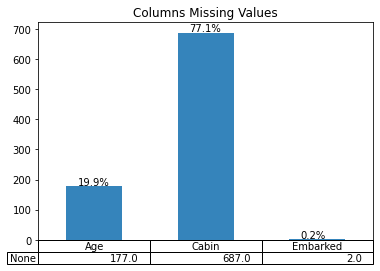

In [123]:
columns_missing = df.isna().sum().where(lambda x : x > 0).dropna()

ax = columns_missing \
.plot(kind='bar', alpha=0.9, title='Columns Missing Values', table=True)
ax.xaxis.set_visible(False) # hide x axis labels

for x in ax.patches:
    ax.text(x.get_x()+.1, x.get_height()+5, \
            str(round((x.get_height()/df.shape[0])*100, 1))+'%')

In [124]:
display(df.groupby(['Pclass', 'Sex'])['Age'].count())

display(df.groupby(['Pclass', 'Sex'])['Age'].median())

Pclass  Sex   
1       female     85
        male      101
2       female     74
        male       99
3       female    102
        male      253
Name: Age, dtype: int64

Pclass  Sex   
1       female    35.0
        male      40.0
2       female    28.0
        male      30.0
3       female    21.5
        male      25.0
Name: Age, dtype: float64

In [125]:
df['Age'] = df.groupby(['Pclass', 'Sex'])['Age'].apply(lambda x: x.fillna(x.median()))
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [126]:
df['Cabin'].unique()

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68',
       'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48',
       'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62 C64',

In [127]:
df['Loc']= df['Cabin'].apply(lambda x: x[0] if pd.notnull(x) else 'X')

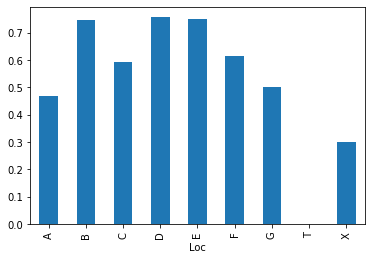

In [128]:
df[['Loc', 'Survived']].groupby('Loc')['Survived'].mean().plot(kind= 'bar')

In [129]:
df.drop(['Cabin', 'Ticket'], axis=1, inplace=True)

In [130]:
df.loc[:,'GroupSize'] = 1 + df['SibSp'] + df['Parch']

In [131]:
df['Embarked'] = df['Embarked'].fillna('S')

In [132]:
LABEL = 'Survived'
columns_to_keep = ['Pclass', 'Sex','Age', 'Fare', 'Embared', 'Deck', 'GroupSize']
columns_to_drop = ['Name','SibSp', 'Parch', 'Survived']
df_train = df
df = df_train.drop(['Name','SibSp', 'Parch', 'PassengerId'], axis=1)

df.head(5)

,Survived,Pclass,Sex,Age,Fare,Embarked,Loc,GroupSize
0,0,3,male,22.0,7.2500,S,X,2
1,1,1,female,38.0,71.2833,C,C,2
2,1,3,female,26.0,7.9250,S,X,1
3,1,1,female,35.0,53.1000,S,C,2
4,0,3,male,35.0,8.0500,S,X,1


In [133]:
import os
script_folder = os.path.join(os.getcwd(), "clean_training_data")
print(script_folder)
os.makedirs(script_folder, exist_ok=True)

/mnt/batch/tasks/shared/LS_root/mounts/clusters/sifakhra2/code/chapter 3/clean_training_data


In [134]:
# df.reset_index(drop=True)

df.to_csv('./clean_training_data/titanic.csv',index=False)
df.head(2)

,Survived,Pclass,Sex,Age,Fare,Embarked,Loc,GroupSize
0,0,3,male,22.0,7.2500,S,X,2
1,1,1,female,38.0,71.2833,C,C,2


In [135]:
from azure.ai.ml.entities import Data
from azure.ai.ml.constants import AssetTypes
my_path = './clean_training_data/titanic.csv'

my_data = Data(
    path=my_path,
    type=AssetTypes.URI_FILE,
    description="description",
    name="titanic-clean-data",
    version='7'
)

ml_client.data.create_or_update(my_data)

Data({'type': 'uri_file', 'is_anonymous': False, 'auto_increment_version': False, 'name': 'titanic-clean-data', 'description': 'description', 'tags': {}, 'properties': {}, 'id': '/subscriptions/dcfc206a-203b-4c00-a236-bdf576a37896/resourceGroups/aml-v2-book/providers/Microsoft.MachineLearningServices/workspaces/aml2-ws/data/titanic-clean-data/versions/7', 'base_path': './', 'creation_context': <azure.ai.ml._restclient.v2022_05_01.models._models_py3.SystemData object at 0x7f62639f1160>, 'serialize': <msrest.serialization.Serializer object at 0x7f6263547dc0>, 'version': '7', 'latest_version': None, 'path': 'azureml://subscriptions/dcfc206a-203b-4c00-a236-bdf576a37896/resourcegroups/aml-v2-book/workspaces/aml2-ws/datastores/workspaceblobstore/paths/LocalUpload/4e9eeca07aa97e8b4eb0500728e8f3d4/titanic.csv', 'referenced_uris': None})

In [136]:
df = df.drop('Survived', axis=1)
df.to_csv('./clean_training_data/test.csv')
df.head(2)

,Pclass,Sex,Age,Fare,Embarked,Loc,GroupSize
0,3,male,22.0,7.2500,S,X,2
1,1,female,38.0,71.2833,C,C,2


In [137]:
from azure.ai.ml.entities import Data
from azure.ai.ml.constants import AssetTypes
my_path = './clean_training_data/test.csv'

my_data = Data(
    path=my_path,
    type=AssetTypes.URI_FILE,
    description="description",
    name="titanic-test-data",
    version='7'
)

ml_client.data.create_or_update(my_data)

Data({'type': 'uri_file', 'is_anonymous': False, 'auto_increment_version': False, 'name': 'titanic-test-data', 'description': 'description', 'tags': {}, 'properties': {}, 'id': '/subscriptions/dcfc206a-203b-4c00-a236-bdf576a37896/resourceGroups/aml-v2-book/providers/Microsoft.MachineLearningServices/workspaces/aml2-ws/data/titanic-test-data/versions/7', 'base_path': './', 'creation_context': <azure.ai.ml._restclient.v2022_05_01.models._models_py3.SystemData object at 0x7f62639f1490>, 'serialize': <msrest.serialization.Serializer object at 0x7f6263b9dac0>, 'version': '7', 'latest_version': None, 'path': 'azureml://subscriptions/dcfc206a-203b-4c00-a236-bdf576a37896/resourcegroups/aml-v2-book/workspaces/aml2-ws/datastores/workspaceblobstore/paths/LocalUpload/410322c5e5922d459cd3bece1bf9cca7/test.csv', 'referenced_uris': None})

In [138]:
import os

data_prep_src_dir = "./components/data_prep"
os.makedirs(data_prep_src_dir, exist_ok=True)

In [139]:
%%writefile {data_prep_src_dir}/data_prep.py
import os
import argparse
import pandas as pd
from sklearn.model_selection import train_test_split
import logging
import mlflow

def main():
    """Main function of the script."""
    # input and output arguments
    parser = argparse.ArgumentParser()
    parser.add_argument("--data", type=str, help="path to input data")
    parser.add_argument("--test_train_ratio", type=float, required=False, default=0.25)
    parser.add_argument("--train_data", type=str, help="path to train data")
    parser.add_argument("--test_data", type=str, help="path to test data")
    args = parser.parse_args()

    # Start Logging
    mlflow.start_run()

    print(" ".join(f"{k}={v}" for k, v in vars(args).items()))
    print("input data:", args.data)
    file_name = os.path.join(args.data)
    titanic_df = pd.read_csv(file_name)
    print(titanic_df.head(10))
    
    mlflow.log_metric("num_samples", titanic_df.shape[0])
    mlflow.log_metric("num_features", titanic_df.shape[1] - 1)
    
    titanic_train_df, titanic_test_df = train_test_split(
        titanic_df,
        test_size=args.test_train_ratio,
    )
    # output paths are mounted as folder, therefore, we are adding a filename to the path
    titanic_train_df.to_csv(os.path.join(args.train_data, "data.csv"), index=True)
    titanic_test_df.to_csv(os.path.join(args.test_data, "data.csv"), index=True)
    # Stop Logging
    mlflow.end_run()

if __name__ == "__main__":
    main()

Overwriting ./components/data_prep/data_prep.py


In [140]:
from azure.ai.ml import command
from azure.ai.ml import Input, Output
from azure.ai.ml.constants import AssetTypes
data_prep_component = command(
    name="data_prep_titanic_survival",
    display_name="Data preparation for training",
    description="reads a .csv input, split the input to train and test",
    inputs={
        "data": Input(type=AssetTypes.URI_FILE),
        "test_train_ratio": Input(type="number"),
    },
    outputs=dict(
        train_data=Output(type="uri_folder", mode="rw_mount"),
        test_data=Output(type="uri_folder", mode="rw_mount"),
    ),
    # The source folder of the component
    code=data_prep_src_dir,
    command="""python data_prep.py \
            --data ${{inputs.data}} --test_train_ratio ${{inputs.test_train_ratio}} \
            --train_data ${{outputs.train_data}} --test_data ${{outputs.test_data}} \
            """,
    environment=f"{pipeline_job_env.name}:{pipeline_job_env.version}",
)

In [141]:
import os

train_src_dir = "./components/train"
os.makedirs(train_src_dir, exist_ok=True)

In [142]:
%%writefile {train_src_dir}/train.py
import argparse
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report
import os
import pandas as pd
import mlflow

import sys
import argparse
import joblib
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import roc_auc_score,roc_curve
# Calculate model performance metrics
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt



def select_first_file(path):
    """Selects first file in folder, use under assumption there is only one file in folder
    Args:
        path (str): path to directory or file to choose
    Returns:
        str: full path of selected file
    """
    files = os.listdir(path)
    return os.path.join(path, files[0])


# Start Logging
mlflow.start_run()

# enable autologging
mlflow.sklearn.autolog()

os.makedirs("./outputs", exist_ok=True)

def buildpreprocessorpipeline(X_raw):
    categorical_features = X_raw.select_dtypes(include=['object']).columns
    numeric_features = X_raw.select_dtypes(include=['float','int64']).columns

    categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value="missing")),
                                              ('onehotencoder', OneHotEncoder(categories='auto', sparse=False, handle_unknown='ignore'))])
    numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('numeric', numeric_transformer, numeric_features),
            ('categorical', categorical_transformer, categorical_features)
        ], remainder="drop")
    
    return preprocessor

def main():
    """Main function of the script."""

    # input and output arguments
    parser = argparse.ArgumentParser()
    parser.add_argument("--train_data", type=str, help="path to train data")
    parser.add_argument("--test_data", type=str, help="path to test data")
    parser.add_argument("--n_estimators", required=False, default=100, type=int)
    parser.add_argument("--learning_rate", required=False, default=0.1, type=float)
    parser.add_argument("--registered_model_name", type=str, help="model name")
    parser.add_argument("--model", type=str, help="path to model file")
    args = parser.parse_args()

    # paths are mounted as folder, therefore, we are selecting the file from folder
    train_df = pd.read_csv(select_first_file(args.train_data))
    test_df = pd.read_csv(select_first_file(args.test_data))
    test_copy = test_df.copy()
    
    
    LABEL = 'Survived'
    X_train = train_df.drop([LABEL], axis=1)
    
    # Extracting the label column
    y_test = test_df.pop(LABEL)

    # convert the dataframe values to array
    X_test = test_copy.drop([LABEL], axis=1)
    lg = LogisticRegression(penalty='l2', C=1.0, solver='liblinear')
    preprocessor = buildpreprocessorpipeline(X_train)
    
    #estimator instance
    clf = Pipeline(steps=[('preprocessor', preprocessor),
                               ('regressor', lg)])

    # Extracting the label column
    y_train = train_df.pop("Survived")    
    model = clf.fit(X_train, y_train)
    
    # calculate AUC
    y_scores = model.predict_proba(X_test)
    auc = roc_auc_score(y_test,y_scores[:,1])
    print('AUC: ' + str(auc))
    
    # Registering the model to the workspace
    print("Registering the model via MLFlow")
    mlflow.sklearn.log_model(
        sk_model=model,
        registered_model_name=args.registered_model_name,
        artifact_path=args.registered_model_name,
    )

    # Saving the model to a file
    mlflow.sklearn.save_model(
        sk_model=clf,
        path=os.path.join(args.model, "trained_model"),
    )

    # Stop Logging
    mlflow.end_run()
if __name__ == "__main__":
    main()

Overwriting ./components/train/train.py


In [143]:
%%writefile {train_src_dir}/train.yml
# <component>
name: train_titanic_survival_model
display_name: Train Titanic Survival Model
# version: 1 # Not specifying a version will automatically update the version
type: command
inputs:
  train_data: 
    type: uri_folder
  test_data: 
    type: uri_folder
  learning_rate:
    type: number     
  registered_model_name:
    type: string
outputs:
  model:
    type: uri_folder
code: .
environment:
  # for this step, we'll use an AzureML curate environment
  azureml:AzureML-sklearn-0.24-ubuntu18.04-py37-cpu:21
command: >-
  python train.py 
  --train_data ${{inputs.train_data}} 
  --test_data ${{inputs.test_data}} 
  --learning_rate ${{inputs.learning_rate}}
  --registered_model_name ${{inputs.registered_model_name}} 
  --model ${{outputs.model}}
# </component>

Overwriting ./components/train/train.yml


In [144]:
# importing the Component Package
from azure.ai.ml import load_component

# Loading the component from the yml file
train_component = load_component(path=os.path.join(train_src_dir, "train.yml"))

In [145]:
# Now we register the component to the workspace
train_component = ml_client.create_or_update(train_component)

# Create (register) the component in your workspace
print(
    f"Component {train_component.name} with Version {train_component.version} is registered"
)

Component train_titanic_survival_model with Version 2022-09-20-23-21-36-8220699 is registered


In [146]:
train_component

CommandComponent({'auto_increment_version': False, 'is_anonymous': False, 'name': 'train_titanic_survival_model', 'description': None, 'tags': {}, 'properties': {}, 'id': '/subscriptions/dcfc206a-203b-4c00-a236-bdf576a37896/resourceGroups/aml-v2-book/providers/Microsoft.MachineLearningServices/workspaces/aml2-ws/components/train_titanic_survival_model/versions/2022-09-20-23-21-36-8220699', 'base_path': './', 'creation_context': <azure.ai.ml._restclient.v2022_05_01.models._models_py3.SystemData object at 0x7f6245357190>, 'serialize': <msrest.serialization.Serializer object at 0x7f6245353850>, 'command': 'python train.py  --train_data ${{inputs.train_data}}  --test_data ${{inputs.test_data}}  --learning_rate ${{inputs.learning_rate}} --registered_model_name ${{inputs.registered_model_name}}  --model ${{outputs.model}}', 'code': '/subscriptions/dcfc206a-203b-4c00-a236-bdf576a37896/resourceGroups/aml-v2-book/providers/Microsoft.MachineLearningServices/workspaces/aml2-ws/codes/6a323ce2-cc5c

In [147]:
# the dsl decorator tells the sdk that we are defining an Azure ML pipeline
from azure.ai.ml import dsl, Input, Output


@dsl.pipeline(
    compute=cpu_compute_target,
    description="Titanic data-prep and model training pipeline",
)
def titanic_survival_pipeline(
    pipeline_job_data_input,
    pipeline_job_test_train_ratio,
    pipeline_job_learning_rate,
    pipeline_job_registered_model_name,
):
    # using data_prep_function like a python call with its own inputs
    data_prep_job = data_prep_component(
        data=pipeline_job_data_input,
        test_train_ratio=pipeline_job_test_train_ratio,
    )

    # using train_func like a python call with its own inputs
    train_job = train_component(
        train_data=data_prep_job.outputs.train_data,  # note: using outputs from previous step
        test_data=data_prep_job.outputs.test_data,  # note: using outputs from previous step
        learning_rate=pipeline_job_learning_rate,  # note: using a pipeline input as parameter
        registered_model_name=pipeline_job_registered_model_name,
    )

    # a pipeline returns a dictionary of outputs
    # keys will code for the pipeline output identifier
    return {
        "pipeline_job_train_data": data_prep_job.outputs.train_data,
        "pipeline_job_test_data": data_prep_job.outputs.test_data,
    }

In [148]:
from azure.ai.ml.constants import AssetTypes

registered_model_name = "titanic_survival_model_"

titanic_dataset = ml_client.data.get("titanic-clean-data", version='7')

# Let's instantiate the pipeline with the parameters of our choice
pipeline = titanic_survival_pipeline(
    # pipeline_job_data_input=credit_data,
    pipeline_job_data_input=Input(type=AssetTypes.URI_FILE, path=titanic_dataset.id),
    pipeline_job_test_train_ratio=0.2,
    pipeline_job_learning_rate=0.25,
    pipeline_job_registered_model_name=registered_model_name,
)

In [149]:
import webbrowser

# submit the pipeline job
pipeline_job = ml_client.jobs.create_or_update(
    pipeline,
    # Project's name
    experiment_name="titanic_remote_cluster",
)
# open the pipeline in web browser
webbrowser.open(pipeline_job.services["Studio"].endpoint)

False

In [150]:
ml_client.jobs.stream(pipeline_job.name)

RunId: cyan_library_14ffbwzyrt
Web View: https://ml.azure.com/runs/cyan_library_14ffbwzyrt?wsid=/subscriptions/dcfc206a-203b-4c00-a236-bdf576a37896/resourcegroups/aml-v2-book/workspaces/aml2-ws

Streaming logs/azureml/executionlogs.txt

[2022-09-20 23:22:02Z] Submitting 1 runs, first five are: aef27a73:0e05fb74-6107-403a-9d79-4281bd5d5f63
[2022-09-20 23:27:40Z] Completing processing run id 0e05fb74-6107-403a-9d79-4281bd5d5f63.
[2022-09-20 23:27:41Z] Submitting 1 runs, first five are: ae47a85e:f692e368-db74-4d50-923e-2ebea20b3dcc
[2022-09-20 23:29:08Z] Completing processing run id f692e368-db74-4d50-923e-2ebea20b3dcc.

Execution Summary
RunId: cyan_library_14ffbwzyrt
Web View: https://ml.azure.com/runs/cyan_library_14ffbwzyrt?wsid=/subscriptions/dcfc206a-203b-4c00-a236-bdf576a37896/resourcegroups/aml-v2-book/workspaces/aml2-ws



In [ ]:
!ipython kernel install --user --name model-env --display-name "model-env"